#➤Importing necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os

# ➤Setup Random seeds for copied values

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Defined Constants

In [4]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data/'


# ➤Function to mount google drive

In [5]:
# ➤ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# ➤Function to check dataset path and class folders

In [6]:
def check_dataset(DATASET_PATH):
    if not os.path.exists(DATASET_PATH):
        raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

    classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    if not classes:
        raise Exception("No class folders found in dataset path!")

    print("Classes found:", classes)

    # Count images in each class folder

    valid_extensions = ['.jpg', '.jpeg', '.png']
    for c in classes:
        class_path = os.path.join(DATASET_PATH, c)
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f)) and os.path.splitext(f)[1].lower() in valid_extensions
        ])
        print(f"{c} -> {num_images} images")

    return classes
classes = check_dataset(DATASET_PATH)


Classes found: ['all', 'train', 'val']
all -> 0 images
train -> 0 images
val -> 0 images


# ➤ Create ImageDataGenerators for training and validation

In [7]:
def create_generators(dataset_path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT,
        # Added augmentation
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        seed=seed
    )

    val_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=seed
    )

    print("Class mapping:", train_gen.class_indices)
    return train_gen, val_gen

train_gen, val_gen = create_generators(DATASET_PATH)

Found 192 images belonging to 3 classes.
Found 46 images belonging to 3 classes.
Class mapping: {'all': 0, 'train': 1, 'val': 2}


# ➤ Visualizing training data images with their class names

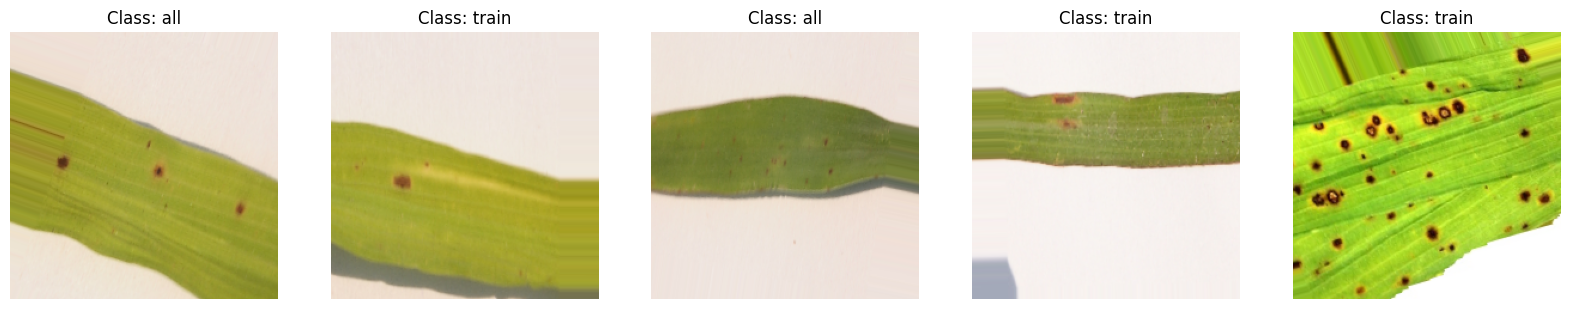

In [8]:
def visualize_samples(train_gen):
    index_to_class = {v: k for k, v in train_gen.class_indices.items()}
    images, labels = next(train_gen)

    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Class: {index_to_class[labels[i].argmax()]}")
        axes[i].axis('off')
    plt.show()
visualize_samples(train_gen)


# ➤ Visualizing validation data images with their class names

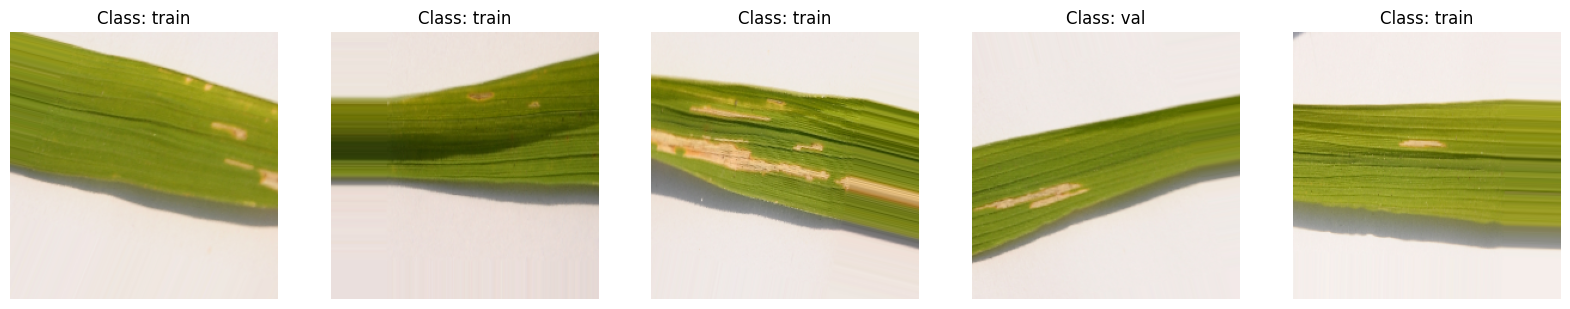

In [9]:
def visualize_samples(val_gen):
    index_to_class = {v: k for k, v in val_gen.class_indices.items()}
    images, labels = next(val_gen)

    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Class: {index_to_class[labels[i].argmax()]}")
        axes[i].axis('off')
    plt.show()
visualize_samples(val_gen)

# ➤Check for class imbalance

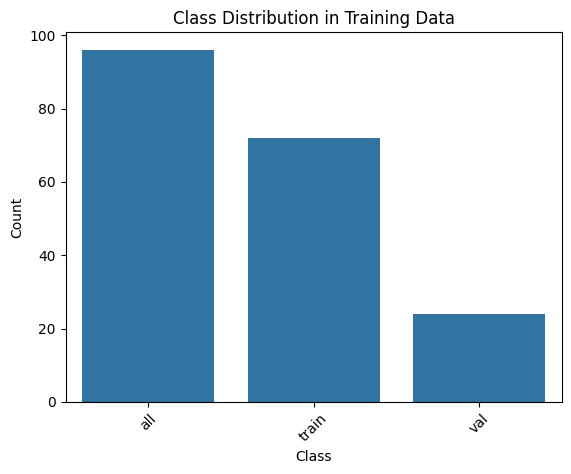

In [10]:
import pandas as pd
import seaborn as sns

class_counts = {k: 0 for k in train_gen.class_indices.keys()}

for c, idx in train_gen.class_indices.items():
    class_counts[c] = sum(train_gen.labels == idx)

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
sns.barplot(data=df, x='Class', y='Count')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

# ➤Check image shapes and types

In [11]:
images,lables = next(train_gen)
print("Train Image batch shape:", images.shape)
print("Train Image data type:", images.dtype)

images,lables = next(val_gen)
print("Validation Image batch shape:", images.shape)
print("Validation Image data type:", images.dtype)

Train Image batch shape: (32, 224, 224, 3)
Train Image data type: float32
Validation Image batch shape: (14, 224, 224, 3)
Validation Image data type: float32


# ➤Display multiple batches of training data to see augmentation effects

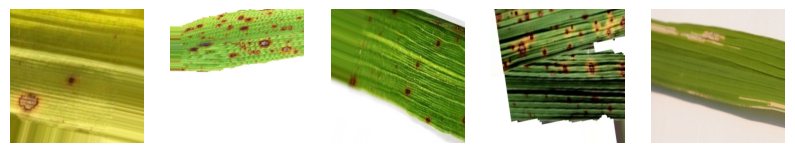

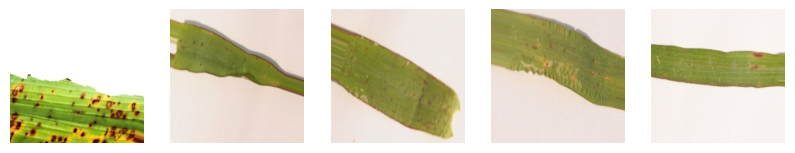

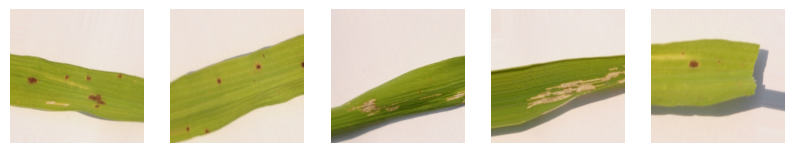

In [12]:
for i in range(3):
    images, labels = next(train_gen)
    plt.figure(figsize=(10, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(images[j])
        plt.axis('off')
    plt.show()


# ➤ Display multiple batches of validation data to see augmentation effect

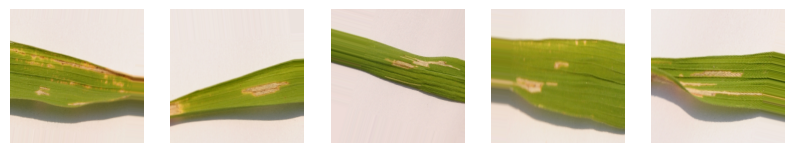

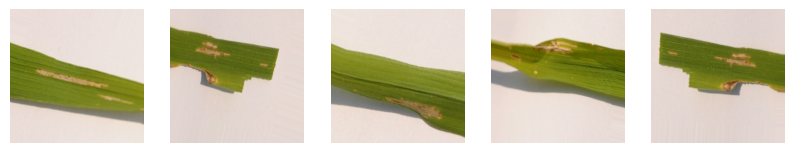

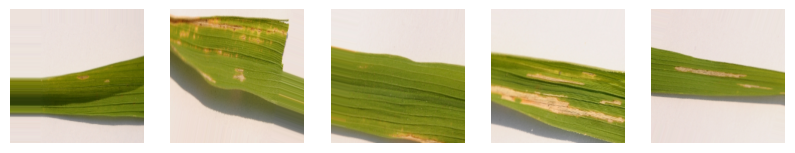

In [13]:
for i in range(3):
    images, labels = next(val_gen)
    plt.figure(figsize=(10, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(images[j])
        plt.axis('off')
    plt.show()

In [14]:
from PIL import Image

from PIL import Image

corrupted_files = []

# Loop through each class folder and check the images
for c in classes:
    class_path = os.path.join(DATASET_PATH, c)
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if image is corrupted
        except Exception as e:
            corrupted_files.append((file, c))

# Print results
if corrupted_files:
    print("Corrupted images found:")
    for file, c in corrupted_files:
        print(f"File: {file} in class {c}")
else:
    print("No corrupted images found!")



Corrupted images found:
File: Brown spot in class all
File: Leaf smut in class all
File: Bacterial leaf blight in class all
File: Leaf smut in class train
File: Brown spot in class train
File: Bacterial leaf blight in class train
File: Leaf smut in class val
File: Brown spot in class val
File: Bacterial leaf blight in class val


1.Corrupted images removed → avoids errors during training.

2.Duplicates removed → prevents bias and overfitting.

3.Hashing ensures only unique images remain.

4.Counters (cleaned, removed) → show dataset quality.

5.Final dataset → clean, consistent, and ready for EDA & model training.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# 1. Count images per class
class_counts = {}
for folder in classes:
    folder_path = os.path.join(DATASET_PATH, folder)
    class_counts[folder] = len(os.listdir(folder_path))

print("Image count per class:", class_counts)


Image count per class: {'all': 3, 'train': 3, 'val': 3}


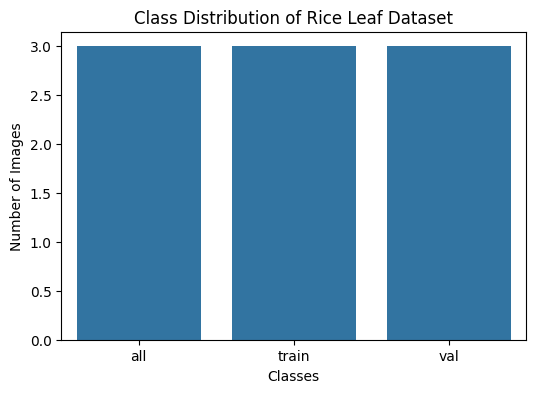

In [16]:
#4. Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution of Rice Leaf Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.show()

In [17]:
# Collect image shapes
img_shapes = []
for folder in classes:
    folder_path = os.path.join(DATASET_PATH, folder)
    for file in os.listdir(folder_path)[:50]:  # check only 50 per class to save time
        img = cv2.imread(os.path.join(folder_path, file))
        if img is not None:
            img_shapes.append(img.shape)

# Show first 10 image shapes
print("Sample image shapes:", img_shapes[:10])

Sample image shapes: []


In [18]:
# Convert to dataframe-like summary
import pandas as pd
shapes_df = pd.DataFrame(img_shapes, columns=["Height", "Width", "Channels"])
print(shapes_df.describe())


       Height Width Channels
count       0     0        0
unique      0     0        0
top       NaN   NaN      NaN
freq      NaN   NaN      NaN


1.Class Distribution → Are all classes balanced? (e.g., Healthy vs Diseased).

2.Sample Images → Quick sanity check (are images clear, correct?).

3.Image Sizes → See if all images are same size or need resizing before CNN.

👉 This tells you about dataset balance, quality, and preprocessing needs.

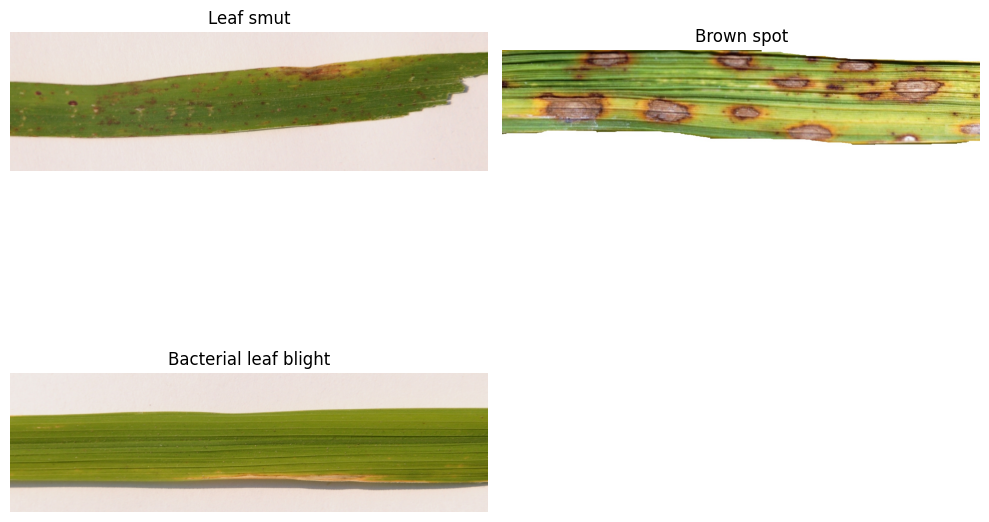

In [19]:
import random
import cv2
import matplotlib.pyplot as plt
import os # Import os module

# Create a 2x2 grid for plotting (since we have 3 classes, a 2x2 grid is still fine)
plt.figure(figsize=(10,8))

# List of class folders to visualize
classes_to_visualize = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']

# Loop through each class
for i, c in enumerate(classes_to_visualize):
    # Construct the correct folder path by joining DATASET_PATH, 'all', and the class name
    folder_path = os.path.join(DATASET_PATH, 'all', c)

    # Check if the folder exists and is not empty
    if os.path.exists(folder_path) and os.listdir(folder_path):
        # Pick a random image from the current class folder
        file = random.choice(os.listdir(folder_path))
        file_path = os.path.join(folder_path, file)

        # Read the image using OpenCV (BGR format by default)
        img = cv2.imread(file_path)

        # Check if the image was loaded successfully
        if img is not None:
            # Convert from BGR → RGB (so colors display correctly in matplotlib)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Plot the image in the grid
            plt.subplot(2, 2, i+1)   # (2 rows, 2 cols, position = i+1)
            plt.imshow(img)
            plt.title(c)             # Set class name as title
            plt.axis("off")          # Hide axis ticks for cleaner look
        else:
            print(f"Warning: Could not load image {file_path}")
    else:
        print(f"Warning: Class folder not found or is empty: {folder_path}")


# Display all images
plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()

1.Resize & batch: Make all images same size (224×224) and process in small groups (32) for efficiency.

2.Normalize: Convert pixel values to 0–1 so the model learns faster.

3.Augmentation: Randomly rotate, shift, zoom, shear, and flip images to create variety and prevent overfitting.

4.Train/Validation split: Use 80% of images for training and 20% to check model performance.

5.Load from directory: Read images in batches and assign numeric labels for each class.

6.Class mapping: Shows which class corresponds to which number for the model.

In short: Images are prepared, varied, split, and labeled so the CNN can learn efficiently and generalize well.

# Model Training

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [21]:
# Create the CNN model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer to prevent overfitting
model.add(Dropout(0.25))

# Flatten the feature maps into a vector
model.add(Flatten())

# Fully connected Dense layer
model.add(Dense(128, activation='relu'))

# Dropout layer for regularization
model.add(Dropout(0.5))

# Output layer with softmax activation for classification
model.add(Dense(len(classes), activation='softmax'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Train the model
model_performance = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5062 - loss: 6.4574 - val_accuracy: 0.4688 - val_loss: 2.7225
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4142 - loss: 1.9661 - val_accuracy: 0.3750 - val_loss: 1.0570
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5013 - loss: 1.0453 - val_accuracy: 0.3750 - val_loss: 0.9854
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4576 - loss: 1.0267 - val_accuracy: 0.5625 - val_loss: 0.9402
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 862ms/step - accuracy: 0.5134 - loss: 1.0208 - val_accuracy: 0.5000 - val_loss: 1.0090
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4365 - loss: 1.0464 - val_accuracy: 0.4688 - val_loss: 1.0277
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 872ms/step - accuracy: 0.4662 - loss: 1.0407 - val_accuracy: 0.4688 - val_loss: 0.9573
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 886ms/step - accuracy: 0.4751 - loss: 1.0434 - val_accuracy: 0.5312 - val_loss: 0.9707
Epoc

# Accuracy Garph

In [24]:
print(model_performance.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


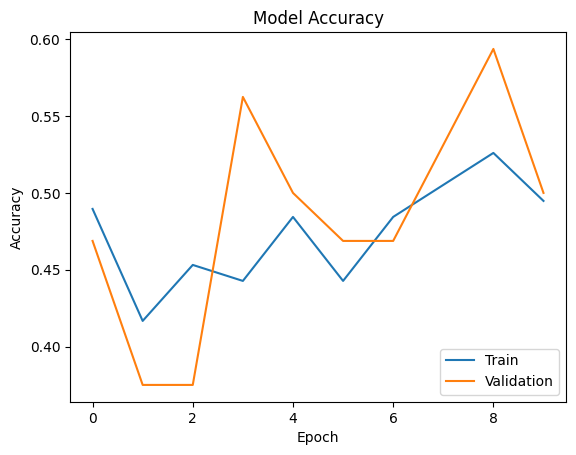

In [25]:
plt.plot(model_performance.history['accuracy'])
plt.plot(model_performance.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


- Training accuracy steadily badh rahi hai, jo dikhata hai ki model apne training data par sahi tareeke se seekh raha hai.
- Validation accuracy mein fluctuations hain — pehle improvement, phir girawat, aur baad mein halka recovery — jo suggest karta hai ki model ko training mein aur epochs ya better tuning ki zarurat ho sakti hai.
- Last ke epochs mein validation accuracy mein instability dikh rahi hai, jo overfitting ya learning rate issue ka signal ho sakta hai.


# Loss Graph

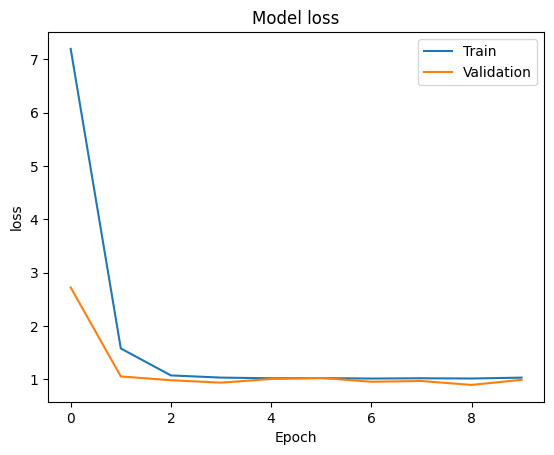

In [26]:
plt.plot(model_performance.history['loss'])
plt.plot(model_performance.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


- Training loss steadily kam ho rahi hai, jo dikhata hai ki model apne training data ko achhi tarah fit kar raha hai.
- Validation loss mein initial improvement ke baad fluctuations aur badhotri dikh rahi hai, jo overfitting ka sanket ho sakta hai.
- Agar model ko aur achha banana hai to regularization techniques, data augmentation ya learning rate tuning ki zarurat ho sakti hai.


# ➤ Saving the trained model

In [27]:
model.save('rice_leaf_disease_model.h5')


# ➤ Loading the saved model

In [28]:
from tensorflow.keras.models import load_model

In [29]:
model = load_model('rice_leaf_disease_model.h5')

# ➤ image upload to predict

In [30]:
from google.colab import files
from tensorflow.keras.preprocessing import image

upload = files.upload()

img_path = list(upload.keys())[0]
print("uploaded image path:", img_path)

Saving DSC_0105.jpg to DSC_0105.jpg
uploaded image path: DSC_0105.jpg


# ➤  Load and preprocessing of  image

In [31]:
import numpy as np

img = image.load_img(img_path,target_size=(224,224))


In [32]:
img_array = image.img_to_array(img)

In [33]:
img_array = np.expand_dims(img_array, axis=0)

In [34]:
img_array = img_array / 255.0

# ➤ Make Prediction

In [35]:
pred = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [36]:
class_idx = np.argmax(pred)

In [37]:
class_names = ['Bacterial leaf blight' , 'Brown spot','leaf smut']

In [38]:
print("Predicted class:",class_names[class_idx])

Predicted class: Brown spot


In [39]:
test_loss, test_accuracy = model.evaluate(val_gen)
print("Test accuracy:", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4896 - loss: 1.0181
Test accuracy: 0.5


# improved version of model



# Hyper-parameter Tunnning
 1) Learning Rate

In [40]:
learning_rates = [0.001, 0.0001, 0.00001]

In [41]:
for lr in learning_rates:
   print(f"\nTraining with learning rate: {lr}")

   model.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
       loss='categorical_crossentropy',
       metrics=['accuracy']
   )

   history = model.fit(
       train_gen,
       validation_data = val_gen,
       epochs=10,
       batch_size= 32,

   )

   val_acc = max(history.history['val_accuracy'])
   print(f"Best validation accuracy: {val_acc}")


Training with learning rate: 0.001
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4626 - loss: 1.0440 - val_accuracy: 0.5000 - val_loss: 1.0000
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 935ms/step - accuracy: 0.4382 - loss: 1.0977 - val_accuracy: 0.5000 - val_loss: 0.9946
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4890 - loss: 1.0075 - val_accuracy: 0.5000 - val_loss: 0.9789
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 946ms/step - accuracy: 0.4952 - loss: 1.0167 - val_accuracy: 0.5000 - val_loss: 0.9931
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5108 - loss: 0.9733 - val_accuracy: 0.5000 - val_loss: 0.9883
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 948ms/step - accuracy: 0.4828 - loss: 0.9560 - val_accuracy: 0.5000 - val_loss: 0.9846
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5185 - loss: 0.9547 - val_accuracy: 0.5000 - val_loss: 0.9950
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 965ms/step - accuracy: 0.4783 - loss: 0.9825 - val_acc

- From this we can analyze that the 0.001 learning rate provides the best validation accuracy with 65%

#  plot graph accuracy vs epochs and loss vs epoch

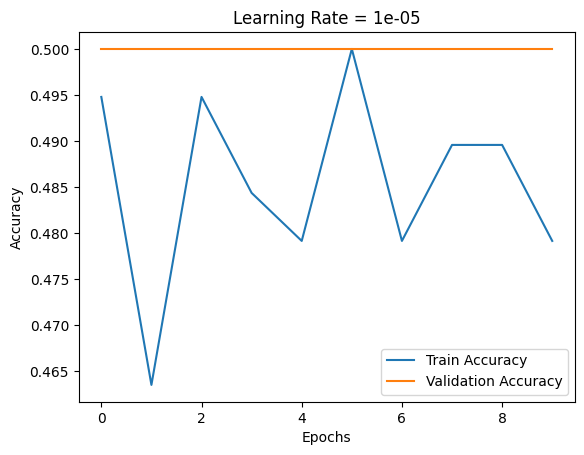

In [42]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f"Learning Rate = {lr}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




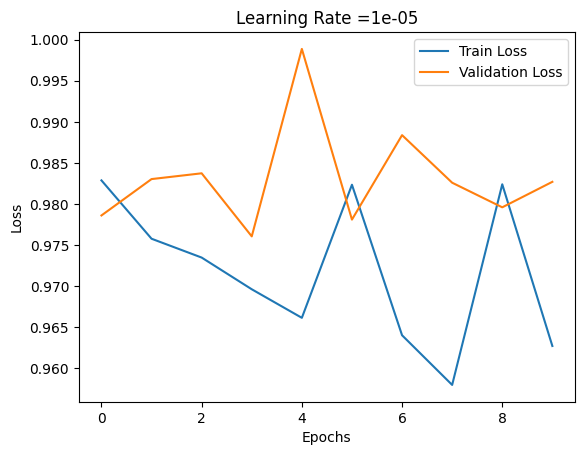

In [43]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f"Learning Rate ={lr}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


- The model is memorizing the training data but not learning general features well.
- The validation accuracy’s instability shows the model isn't adapting well to new data.
- A higher learning rate like 0.001 is more suitable for faster, more stable learning.

# Batch Size tunning

In [44]:
batch_sizes = [16, 32, 64]
learning_rate = 0.001


In [45]:
for batch_size in batch_sizes:
  print(f"\nTraining with batch size: {batch_size}")




Training with batch size: 16

Training with batch size: 32

Training with batch size: 64


In [46]:
# Recreating the model for experiment weighs
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
    )
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])


In [48]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [49]:
history = model.fit(
       train_gen,
       validation_data = val_gen,
       epochs=20,
       batch_size= batch_size,

   )
val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy for batch size {batch_size}: {val_acc}")

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.3721 - loss: 1.6144 - val_accuracy: 0.4348 - val_loss: 1.2638
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4712 - loss: 1.2726 - val_accuracy: 0.5217 - val_loss: 1.0263
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 938ms/step - accuracy: 0.5091 - loss: 1.0104 - val_accuracy: 0.4565 - val_loss: 1.0335
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5109 - loss: 1.0111 - val_accuracy: 0.5000 - val_loss: 0.9482
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 915ms/step - accuracy: 0.4094 - loss: 0.9817 - val_accuracy: 0.4783 - val_loss: 0.9927
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4275 - loss: 1.0391 - val_accuracy: 0.4783 - val_loss: 1.0002
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 932ms/step - accuracy: 0.4742 - loss: 0.9616 - val_accuracy: 0.5217 - val_loss: 0.9960
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5012 - loss: 0.9571 - val_accuracy: 0.5000 - val_loss: 1.0003
Epoch 

# data augmentation

In [50]:
import os
import random
import shutil

# Mount Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data'
all_dir = os.path.join(base_dir, 'all')  # Original images folder
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List of class folders
classes = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']  # Adjust according to your dataset

# Create subfolders inside train and val
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Train-validation split ratio
train_ratio = 0.75

# Split and move images
for cls in classes:
    cls_all_path = os.path.join(all_dir, cls)
    images = os.listdir(cls_all_path)
    random.shuffle(images)

    train_count = int(len(images) * train_ratio)
    train_images = images[:train_count]
    val_images = images[train_count:]

    print(f"Class '{cls}': {len(train_images)} train and {len(val_images)} val images.")

    # Move train images
    for img in train_images:
        src = os.path.join(cls_all_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copy(src, dst)

    # Move val images
    for img in val_images:
        src = os.path.join(cls_all_path, img)
        dst = os.path.join(val_dir, cls, img)
        shutil.copy(src, dst)

print("Data split completed successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class 'Leaf smut': 29 train and 10 val images.
Class 'Brown spot': 30 train and 10 val images.
Class 'Bacterial leaf blight': 30 train and 10 val images.
Data split completed successfully!


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data/val'


# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled, no augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,   # Use the batch size you found best
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Get the number of classes
num_classes = len(train_generator.class_indices)


Found 111 images belonging to 3 classes.
Found 52 images belonging to 3 classes.


In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 27s/step - accuracy: 0.4057 - loss: 1.2160 - val_accuracy: 0.5000 - val_loss: 1.0857
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5358 - loss: 1.1369 - val_accuracy: 0.5385 - val_loss: 1.0246
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5142 - loss: 1.0302 - val_accuracy: 0.6154 - val_loss: 0.9722
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.5306 - loss: 1.0290 - val_accuracy: 0.6154 - val_loss: 0.9077
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5875 - loss: 0.9458 - val_accuracy: 0.6923 - val_loss: 0.8424
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6212 - loss: 0.8477 - val_accuracy: 0.7500 - val_loss: 0.7776
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6763 - loss: 0.8184 - val_accuracy: 0.8077 - val_loss: 0.7172
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7991 - loss: 0.7217 - val_accuracy: 0.8462 - val_loss: 0.6542
Epoch 9/30
2/2

# Adding callbacks and modelcheckpoint

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9372 - loss: 0.2429

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.9371 - loss: 0.2411 - val_accuracy: 0.9423 - val_loss: 0.1805
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.9045 - loss: 0.2437 - val_accuracy: 0.9423 - val_loss: 0.1859
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9304 - loss: 0.2092

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.9356 - loss: 0.2093 - val_accuracy: 0.9615 - val_loss: 0.1880
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9449 - loss: 0.2339 - val_accuracy: 0.9615 - val_loss: 0.1706
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.9197 - loss: 0.2271 - val_accuracy: 0.9615 - val_loss: 0.1500
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9498 - loss: 0.1500 - val_accuracy: 0.9615 - val_loss: 0.1384
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9094 - loss: 0.2174 - val_accuracy: 0.9615 - val_loss: 0.1368
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9423 - loss: 0.2108 - val_accuracy: 0.9615 - val_loss: 0.1345
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9678 - loss: 0.1521 - val_accuracy: 0.9615 - val_loss: 0.1336
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9604 - loss: 0.1386 - val_accuracy: 0.9615 - val_loss: 0.1364
Epoch 11/30
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9259 - loss: 0.1603 - val_accuracy: 0.9808 - val_loss: 0.1085
Epoch 15/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9543 - loss: 0.1829 - val_accuracy: 0.9808 - val_loss: 0.0976
Epoch 16/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9738 - loss: 0.1232 - val_accuracy: 0.9808 - val_loss: 0.0953
Epoch 17/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9809 - loss: 0.1151 - val_accuracy: 0.9615 - val_loss: 0.0989
Epoch 18/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9487 - loss: 0.1478 - val_accuracy: 0.9615 - val_loss: 0.1122
Epoch 19/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9509 - loss: 0.1253 - val_accuracy: 0.9615 - val_loss: 0.1160
Epoch 20/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9551 - loss: 0.1585 - val_accuracy: 0.9808 - val_loss: 0.1020
Epoch 21/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9749 - loss: 0.0959 - val_accuracy: 0.9808 - val_loss: 0.0956


# performance check

In [54]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9808 - loss: 0.0953
Validation Accuracy: 98.08%
Validation Loss: 0.0953


# confusion matrix

In [55]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [56]:
y_true = val_generator.classes

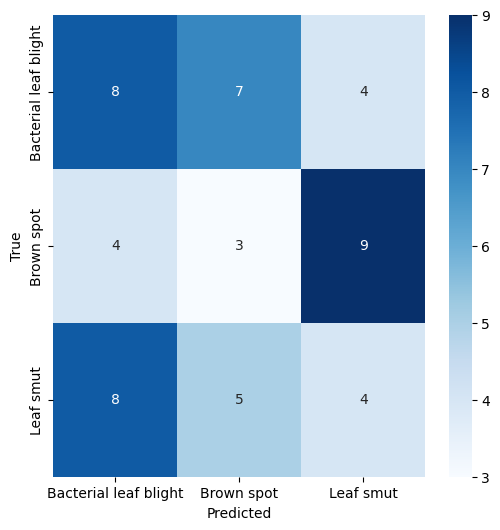

In [57]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# classification report

In [58]:
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))


                       precision    recall  f1-score   support

Bacterial leaf blight       0.40      0.42      0.41        19
           Brown spot       0.20      0.19      0.19        16
            Leaf smut       0.24      0.24      0.24        17

             accuracy                           0.29        52
            macro avg       0.28      0.28      0.28        52
         weighted avg       0.28      0.29      0.29        52



# Testing

In [60]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data/val/Brown spot/DSC_0101.jpg'  # change to your image
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
classes = list(val_generator.class_indices.keys())
print("Prediction:", classes[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: Brown spot


In [61]:
model.save("rice_leaf_disease_model.h5")
# Load later
from tensorflow.keras.models import load_model
loaded_model = load_model("rice_leaf_disease_model.h5")


In [62]:
!pip install gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load your saved model
model = tf.keras.models.load_model("rice_leaf_disease_model.h5")

# Class names (must match your dataset classes)
class_names = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']  # change if more classes

# Prediction function
def predict(img):
    img = img.resize((224, 224))  # resize to model input size
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Rice Leaf Disease Detection",
    description="Upload a rice leaf image to classify whether it's healthy or diseased."
)

# Launch interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c6a86485f93224dc04.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
